In [1]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
from scipy.signal import find_peaks

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

In [2]:
profile_folder = 'A3DOWN 2006-06-09 (S-800, 30-15cm)'

a3downDF = mgl.readWiebeFiles(profile_folder, resolution = 1)
a3downDF.head()

,-15,-2,1,4,10,16,23,30,39,48,...,211,222,233,244,255,266,277,289,300,301
0.000000,-0.000500,0.003600,-0.010300,-0.011100,-0.014200,-0.013300,-0.006800,-0.007700,-0.009400,-0.013200,...,-0.006400,-0.017500,-0.029500,-0.048200,-0.003800,-0.003100,-0.000400,-0.028200,-0.028100,-0.003400
0.015019,0.003206,0.006445,-0.006348,-0.007636,-0.011491,-0.011955,-0.004730,-0.005294,-0.007300,-0.010597,...,-0.004200,-0.014045,-0.026536,-0.047906,-0.002697,-0.001282,0.001173,-0.026245,-0.026315,-0.001355
0.030038,0.006834,0.008845,-0.004634,-0.005957,-0.009834,-0.011527,-0.004734,-0.003312,-0.006049,-0.010800,...,-0.001700,-0.011452,-0.024193,-0.049200,-0.002516,0.001034,0.003134,-0.024434,-0.025655,0.000134
0.045056,0.009261,0.011189,-0.002524,-0.004200,-0.008598,-0.011635,-0.005833,-0.002922,-0.006028,-0.011211,...,-0.000200,-0.009062,-0.023456,-0.048400,-0.005978,0.002511,0.004789,-0.022542,-0.023347,0.000095
0.060075,0.011500,0.013151,-0.000200,-0.002273,-0.009014,-0.011141,-0.005318,-0.002931,-0.005385,-0.011241,...,0.000544,-0.008026,-0.022652,-0.046518,-0.010648,0.002600,0.005598,-0.021771,-0.023189,0.000849


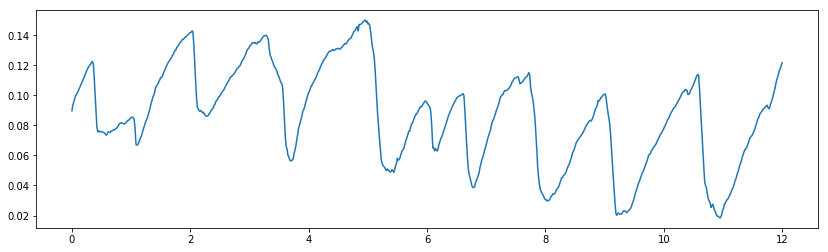

In [3]:
x0 = a3downDF.index.values
z0 = a3downDF[1].values + 0.1

fig = plt.figure(figsize=(14, 4))
plt.plot(x0, z0)

dx = x0[1]-x0[0]

In [4]:
def make_animation(verts):
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=(12, 3))
    ax = plt.axes(xlim=(0, 10), ylim=(0, 0.2))

    x0 = verts[0,:,0]
    z0 = verts[0,:,1]

    plt.plot(x0,z0)
    line, = ax.plot([], [], lw=2)



    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = verts[i,:,0]
        y = verts[i,:,1]
        line.set_data(x, y)
        return line,
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=verts.shape[0], interval=80, blit=True)
    return anim

 Starting simulation....
Number of time steps: 150.0 mins
Grid dx = 0.015018773466833541
Grid nx = 800
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.0 - Elevation 0.0869983040735722
Courant number: max 0.18114736028213319, mean0.11257798675296563
Time step: 2.0 mins - uavg: 0.0 - Elevation 0.08699830407366271
Courant number: max 0.15704191344102414, mean0.10354902440504196
Time step: 3.0 mins - uavg: 0.0 - Elevation 0.08699830407392334
Courant number: max 0.13848293854112237, mean0.09616760846123938
Time step: 4.0 mins - uavg: 0.0 - Elevation 0.0869983040739836
Courant number: max 0.12377889354206494, mean0.09006789871614647
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.08699830407399813
Courant number: max 0.11199588913119982, mean0.08498581111099761
Time step: 6.0 mins - uavg: 0.0 - Elevation 0.0869983040741376
Courant number: max 0.10246593461717911, mean0.

Text(0, 0.5, 'z (m)')

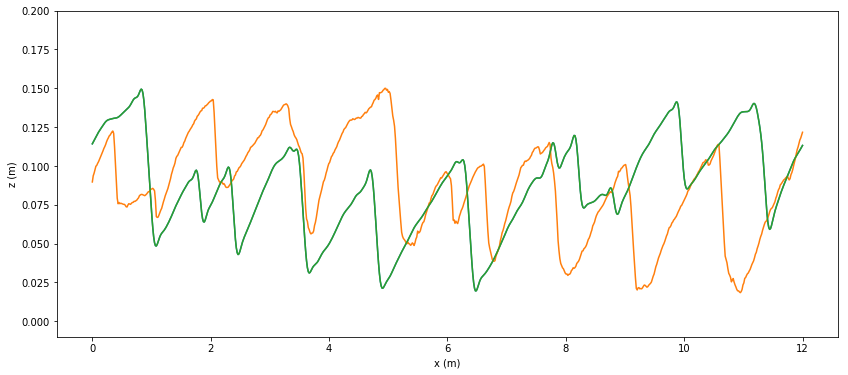

In [6]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*300     # Runtime in seconds
dt = 2               # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*1

run_name = 'A3_Parameterized_decreasing'.format('32m','357mm')

model = sdmodels.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)
plt.ylim([-0.01, 0.20])
plt.xlabel('x (m)')
plt.ylabel('z (m)')

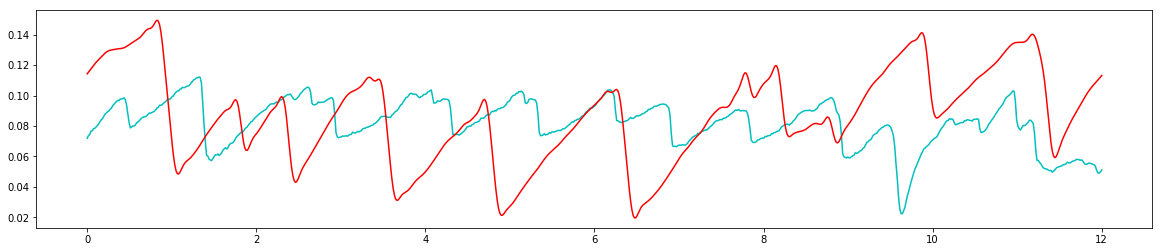

In [8]:
fig = plt.figure(figsize=(20, 4))
#plt.plot(xc,a3downDF[1]+0.1,'g')
plt.plot(xc,a3downDF[300]+ 0.1,'c')
plt.plot(x0,zc,'r')

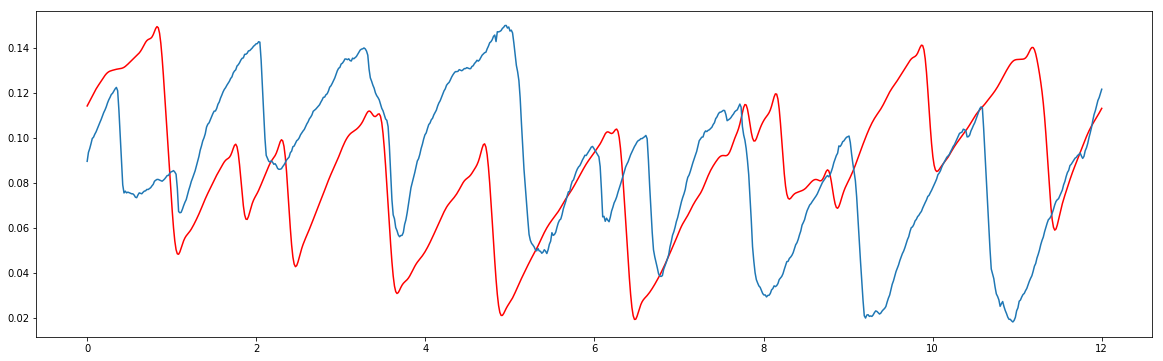

In [9]:
fig = plt.figure(figsize=(20, 6))
plt.plot(xc,zc, 'r')
plt.plot(x0,z0)

2019-05-31 16:16:12,654 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2019-05-31 16:16:12,656 INFO CLAW: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x216', '-pix_fmt', 'rgba', '-r', '12.5', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpw730lggm/temp.m4v']


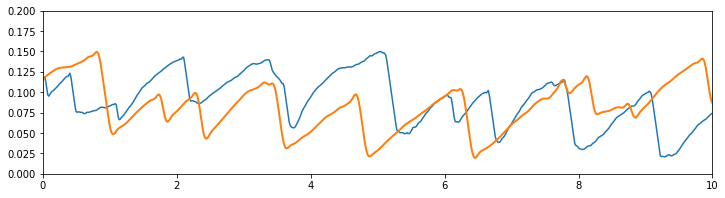

In [10]:
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))

make_animation(verts)

In [ ]:
qsb = model._calculate_bedload(0, 0, x0, z0, 0, 0)
plt.plot(x0, qsb)